In [1]:
import numpy as np
from numba import njit, jit, vectorize, float64, prange
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
from os.path import exists
from scipy import stats

mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 11
mpl.rcParams["font.size"] = 11
plt.rc("text", usetex=False)
plt.rc("text.latex", preamble=r"""
\usepackage{palatino}
\usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [2]:
def confidence_intervals(sample_variances, p):
    """
    Returns the 100(1-p)% confidence intervals
    sample_variances    ----------
    sample_variances: array
        array of sample variances
    
    p: float between 0 and 1 exclusive
        p-value for confidence interval
        
    Returns
    -------
    intervals: array of floats
        |x - μ| < intervals, where X is the sample mean
        
    Notes
    -----
    Calculated as
        `stats.t.ppf(q = 1 - p/2, df=n-1) * np.sqrt(sample_variances)/np.sqrt(n)`
    where n = `len(sample_variances)`
    """
    n = len(sample_variances)
    intervals = stats.t.ppf(q = 1 - p/2, df=n-1) * np.sqrt(sample_variances)/np.sqrt(n)
    return intervals

In [3]:
@njit
def random_uniform(low = 0.0, high = 1.0, size = 1, seed = 0):
    if (seed):
        np.random.seed(seed)
        
    randos = np.random.random(size = size)
    scale = np.abs(high - low)
    randos *= scale
    randos += low
    return randos

@njit
def random_uniform_orthogonal(nax, l_bounds, u_bounds, seed = 0):
    """
    TODO: license
    TODO: docstring
    TODO: seeding?
    """
    if (seed):
        np.random.seed(seed)
        
    N = np.power(nax, 2)
    x_scale = (u_bounds[0] - l_bounds[0])/N
    y_scale = (u_bounds[1] - l_bounds[1])/N
    x0 = l_bounds[0]
    y0 = l_bounds[1]
    xlist = np.arange(N).reshape((nax,nax))
    ylist = np.arange(N).reshape((nax,nax))
    x_randos = np.empty(N, dtype = np.float64)
    y_randos = np.empty(N, dtype = np.float64)
    for i in range(nax):
        xlist[i] = np.random.permutation(xlist[i])
        ylist[i] = np.random.permutation(ylist[i])
    for i in range(nax):
        for j in range(nax):
            x_randos[i*nax + j] = x0 + x_scale * (xlist[i][j] + (np.random.random()))
            y_randos[i*nax + j] = y0 + y_scale * (ylist[j][i] + (np.random.random()))
    return x_randos, y_randos

In [4]:
@jit(nopython = True)
def default_escape_cond(z):
    return np.abs(z) >= 2

@jit(nopython = True)
def main_cardioid(arg):
    point = 0.5 * np.exp(1j*arg) - 0.25 * np.exp(2*1j*arg)
    return np.abs(point)

#@jit(nopython = True)
#def cardioid_escape_cond(z):
    #if np.abs(z) <= main_cardioid(z.)

def mandelbrot_batch_factory(escape_condition):
    @jit(nopython = True, parallel = True, nogil = True)
    def _mandelbrot_mc(max_iter, samples):
        iter_counts = np.empty(len(samples), dtype = np.int64)
        for i in prange(len(samples)):
            c = samples[i]
            zn = c
            for count in range(max_iter):
                zn = zn * zn + c
                if (escape_condition(zn)):
                    iter_counts[i] = count
                    break
                elif count == max_iter - 1:
                    iter_counts[i] = count
        return iter_counts
    return _mandelbrot_mc

mandelbrot_mc_default = mandelbrot_batch_factory(default_escape_cond)

@njit
def create_batch_uniform(N, re_low, re_high, im_low, im_high, seed = 0):
    if (seed):
        np.random.seed(seed)
    samples_re = random_uniform(low = re_low, high = re_high, size = N)
    samples_im = random_uniform(low = im_low, high = im_high, size = N)
    samples = samples_re + 1j*samples_im
    return samples

@njit
def create_batch_orthogonal(N, re_low, re_high, im_low, im_high, seed = 0):
    if (seed):
        np.random.seed(seed)
    nax = np.int64(np.ceil(np.sqrt(N)))
    l_bounds = (re_low, im_low)
    u_bounds = (re_high, im_high)
    samples_re, samples_im = random_uniform_orthogonal(nax, l_bounds, u_bounds)
    samples = samples_re + 1j*samples_im
    samples = samples[:N]
    return samples

def create_batch_lhc(N, re_low, re_high, im_low, im_high, seed = 0):
    if (seed):
        sampler = stats.qmc.LatinHypercube(d = 2, seed = seed)
    else:
        sampler = stats.qmc.LatinHypercube(d = 2)
    re_scale = re_high - re_low
    im_scale = im_high - im_low
    samples = sampler.random(N)
    samples[:,0] *= re_scale
    samples[:,1] *= im_scale
    samples[:,0] += re_low
    samples[:,1] += im_low
    samples = samples[:,0] + 1j*samples[:,1]
    return samples

@njit
def genrand_uniform(low = 0.0, high = 1.0, size = 1, sampler = random_uniform):
    return sampler(low, high, size)

In [5]:
@jit(nopython = True)
def set_count_from_iter_counts(max_iter, iter_counts):
    set_count = 0
    for count in iter_counts:
        if count == max_iter - 1:
            set_count += 1
    return set_count

@jit(nopython = True)
def area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, max_iter):
    n = len(iter_counts)
    set_count = set_count_from_iter_counts(max_iter, iter_counts)
    domain_area = (re_high - re_low) * (im_high - im_low)
    return domain_area * set_count / n

In [6]:
@jit(nopython = True, parallel = True, nogil = True)
def mandelbrot_mc(max_iter, samples):
    """
    Counts the number of complex numbers in `samples` that do
    not meet the escape condition in `max_iter` recursions of
    the Mandelbrot polynomial, z(n+1) = z(n)^2 + c
    
    The escape condition used is |z(n)| >= 2
    
    Parameters
    ----------
    max_iter: positive integer
        Value of n up to which z(n) is evaluated
    
    samples: array of complex numbers
        values of z(0)
        
    Returns
    -------
    set_count: positive integer
        Number of complex numbers in `samples` that remain
        that do not satisfy the escape condition
    """
    set_count = 0
    for i in prange(len(samples)):
        c = samples[i]
        zn = c
        for j in range(1, max_iter):
            zn = zn*zn + c
            if (np.abs(zn) > 2):
                # numba should recognize this as a critical section
                break
            elif j == max_iter - 1:
                set_count += 1
    return set_count

@jit(nopython = True, nogil = True, parallel = True)
def mandelbrot_mc_area(re_low, re_high, im_low, im_high, max_iter, samples):
    """
    Calculates estimator of the area of the Mandelbrot set
    
    Parameters
    ----------
    re_low, re_high, im_low, im_high: float or float-like
        corners of bounding rectangle in the complex plane
    
    max_iter: positive integer
        value of n up to which z(n) is evaluated
    
    samples: array of complex numbers
        list of c values, assumed to be drawn from a uniform distribution
        in the bounding region
        
    Returns
    -------
    area: default numpy float (float32 or float64)
        estimate of the area of the mandelbrot set
    """
    count = mandelbrot_mc(max_iter, samples)
    return mandelbrot_area(count, len(samples), re_low, re_high, im_low, im_high)

@jit(nopython = True)
def mandelbrot_area(count, N, re_low, re_high, im_low, im_high):
    """
    TODO: Add docstring
    """
    rect_area = (re_high - re_low) * (im_high - im_low)
    return rect_area * count / N

@jit(nopython = True)
def mandelbrot_mc_runs(max_iter, samples, runs_count):
    counts = np.zeros(runs_count)
    for _ in range(runs_count):
        counts[i] = mandelbrot_mc(max_iter, samples)
    return counts

@jit(nopython = True)
def sample_mean_variance(counts):
    """Returns sample mean and sample variance of input array
    Parameters
    ----------
    counts: array of numbers
    
    Returns: 2-tuple (sample mean, sample variance)
    """
    n = len(counts)
    assert n > 1
    sample_mean = np.mean(counts)
    sample_variance = np.sum(np.power(counts - sample_mean, 2))/(n - 1)
    return (sample_mean, sample_variance)

In [7]:
N = 10**6
i = 1000
re_low, re_high = -2., 1.
im_low, im_high = 0, 1.5
area = (re_high - re_low) * (im_high - im_low)
samples = create_batch_uniform(N, re_low, re_high, im_low, im_high)

In [8]:
start_time = timer()
count = mandelbrot_mc_default(i, samples)
end_time = timer()
print(f"Execution time: {np.round(end_time - start_time, 2)} seconds")
print(area_from_iter_counts(re_low, re_high, im_low, im_high, count, i) * 2)

Execution time: 0.54 seconds
1.506816


In [9]:
# # [WARN]: On Linux Mint 20, 16GB RAM, 2GB swap space, the kernel crashes as it runs out of memory for N = 1.0e9
# N = 10**8
# # TODO: save large random arrays
# np.random.seed(10010)
# samples = create_batch_uniform(N, re_low, re_high, im_low, im_high)

In [10]:
# start_time = timer()
# count = mandelbrot_mc_default(i,samples)
# end_time = timer()
# print(end_time - start_time)

In [11]:
s = 10**5
i_values = np.array([10**i for i in range(1,8)], dtype = np.int64)

re_low, re_high = -2., 1.
im_low, im_high = 0, 1.5

npz_filename = "mc_fixed_s.npz"

mean_areas = np.empty(len(i_values))
sample_variances = np.empty(len(i_values))

if not exists(npz_filename):
    number_of_batches = 50
    for k,i in enumerate(i_values):
        areas_batch = np.empty(number_of_batches)
        for j in range(number_of_batches):
            samples = create_batch_uniform(s, re_low, re_high, im_low, im_high)
            iter_counts = mandelbrot_mc_default(i, samples)
            est_area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
            areas_batch[j] = est_area
        μ, svar = sample_mean_variance(areas_batch)
        mean_areas[k] = μ
        sample_variances[k] = svar
    np.savez(npz_filename, mean_areas, sample_variances)
else:
    save_data = np.load(npz_filename)
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']
    
confidence_95 = confidence_intervals(sample_variances, p = 0.05)

assert len(mean_areas) ==  len(sample_variances) == len(i_values)

In [12]:
print(mean_areas * 2)

[2.0245032 1.5460776 1.5106986 1.5087114 1.506816  1.5078708 1.5051294]


In [13]:
#TODO: plotting

def compute_difference(means):
    i = [c for c in means]
    max_area = i[-1]

    return np.abs(i - max_area)

def iteration_variance_fixed_s(simulation_data, title):
    """"
    Plots mean area and standard deviation of the mandelbrot set 
    against sample sizes simulated with different number of 
    iterations
    """
    i_values = np.array([10**i for i in range(1,8)], dtype = np.int64)
    
    data = np.load(simulation_data)
    
    mean_areas = data['arr_0']*2
    
    sample_variances = data['arr_1']*2
    
    confidence_95 = confidence_intervals(sample_variances, p = 0.05)
    
    difference = compute_difference(means = mean_areas)

    ax = plt.gca() 

    plt.plot(i_values, mean_areas, alpha = 0.5, label = "Fixed s = $10^5")
    plt.fill_between(i_values, mean_areas - confidence_95, mean_areas + confidence_95, alpha = 0.2)
    
    plt.xlabel("Iterations")
    plt.ylim(0.8, 2.28)
    ax.set_ylabel("Mandelbrot area")
    plt.grid(True)
    ax.legend(loc="upper right", fontsize="x-small")
    
    ax2 = ax.twinx()
    ax2.plot(i_values, difference, color = 'darkblue', linestyle = "--")
    ax2.tick_params(axis='y', labelcolor='royalblue')
    ax2.legend(loc="upper right", fontsize="x-small")
    ax2.set_ylabel("Difference |A(i,s) - A(j,s)|", color = 'royalblue')
    
    ax.set_xscale('log')
    
    plt.savefig(title)
    plt.show() 

No handles with labels found to put in legend.


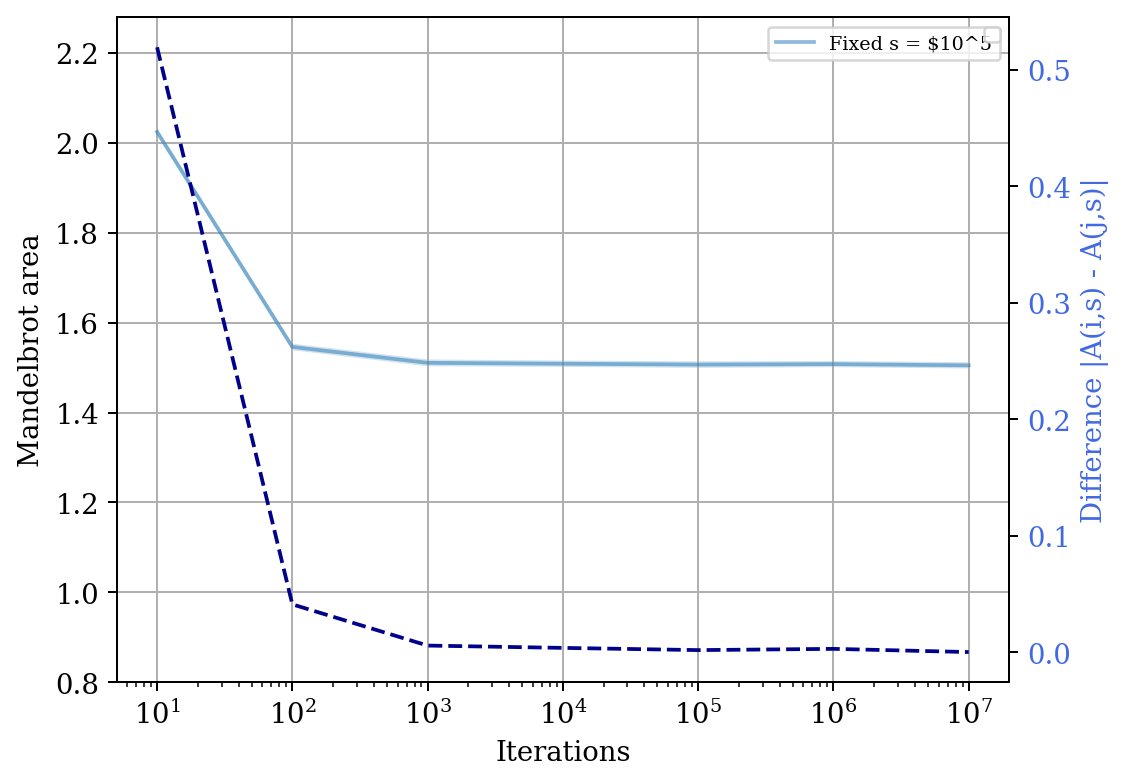

In [14]:
iteration_variance_fixed_s(simulation_data = "mc_fixed_s.npz" , title = "I_variance_s_fixed.png")

In [15]:
i = 2500
s_values = np.array([10**s for s in range(1,8)], dtype = np.int64)

re_low, re_high = -2., 1.
im_low, im_high = 0, 1.5

npz_filename = "mc_fixed_i.npz"

mean_areas = np.empty(len(s_values))
sample_variances = np.empty(len(s_values))

if not exists(npz_filename):
    number_of_batches = 50
    for k,s in enumerate(s_values):
        areas_batch = np.empty(number_of_batches)
        for j in range(number_of_batches):
            samples = create_batch_uniform(s, re_low, re_high, im_low, im_high)
            iter_counts = mandelbrot_mc_default(i, samples)
            est_area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
            areas_batch[j] = est_area
        μ, svar = sample_mean_variance(areas_batch)
        mean_areas[k] = μ
        sample_variances[k] = svar
    np.savez(npz_filename, mean_areas, sample_variances)
else:
    save_data = np.load(npz_filename)
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']
    
confidence_95 = confidence_intervals(sample_variances, p = 0.05)

assert len(mean_areas) ==  len(sample_variances) == len(s_values)

In [16]:
print(mean_areas * 2)

[1.602      1.5354     1.54296    1.51524    1.5111324  1.50780816
 1.50778742]


In [17]:
def sample_variance_fixed_i(simulation_data, title):
    """"
    Plots mean area and standard deviation of the mandelbrot set 
    against sample sizes simulated with different number of 
    iterations
    """
    s_values = np.array([10**s for s in range(1,8)], dtype = np.int64)
    
    data = np.load(simulation_data)
    
    mean_areas = data['arr_0']*2
    
    sample_variances = data['arr_1']*2
    
    confidence_95 = confidence_intervals(sample_variances, p = 0.05)
    
    difference = compute_difference(means = mean_areas)

    ax = plt.gca() 

    plt.plot(s_values, mean_areas, alpha = 0.5, label = "Fixed i = 2500")
    plt.fill_between(s_values, mean_areas - confidence_95, mean_areas + confidence_95, alpha = 0.2)
    
    plt.xlabel("Sample size")
    plt.ylim(0.8, 2.28)
    plt.xscale('log')
    ax.set_ylabel("Mandelbrot area")
    plt.grid(True)
    ax.legend(loc="upper right", fontsize="x-small")
    
    ax2 = ax.twinx()
    ax2.plot(s_values, difference, color = 'darkblue', linestyle = "--")
    ax2.tick_params(axis='y', labelcolor='royalblue')
    ax2.legend(loc="upper right", fontsize="x-small")
    ax2.set_ylabel("Difference |A(i,s) - A(i,s)|", color = 'royalblue')
    
    plt.savefig(title)
    plt.show() 

No handles with labels found to put in legend.


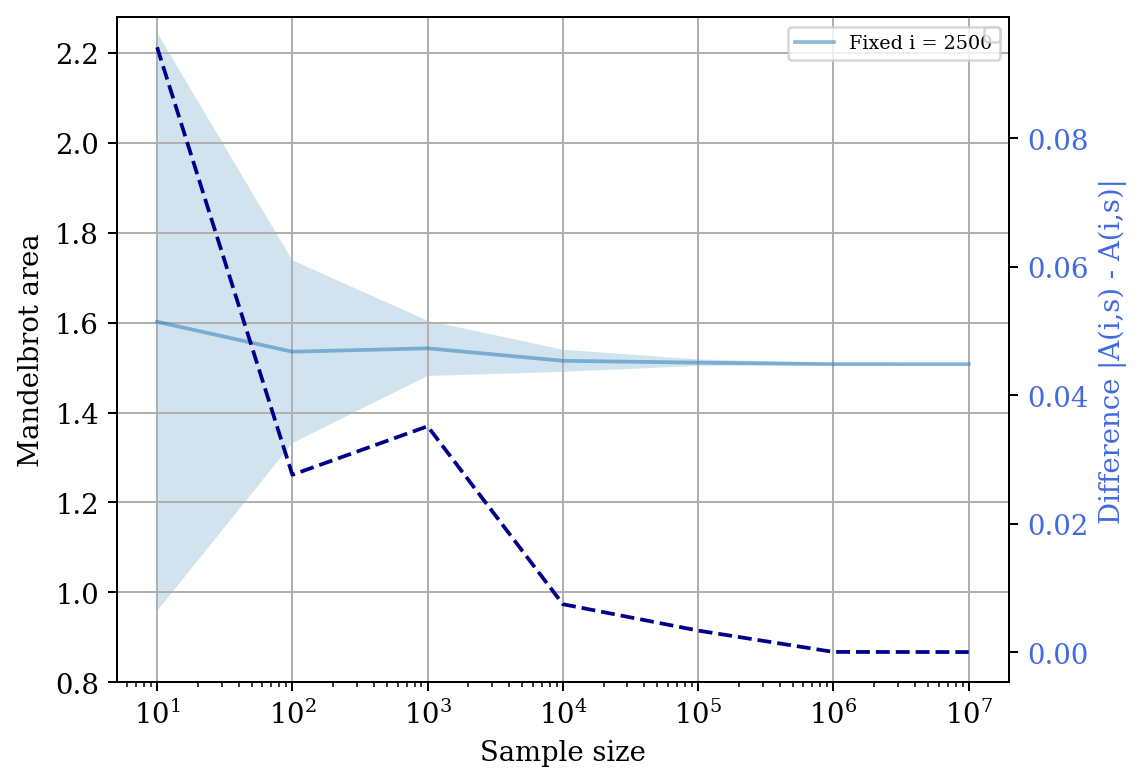

In [18]:
sample_variance_fixed_i(simulation_data = "mc_fixed_i.npz", title = "S_variance_i_fixed.png")

For a fixed $i$, $\lim_{s\to\infty}A_{i,s} = A_i > A_\text{M}$, i.e. we are essentially calculating the area of a superset of the Mandelbrot set, one that includes points that would have met the escape condition after $i$ iterations.

Given a strictly increasing sequence of $i$-values $\{i_1, i_2, \ldots i_n\}$, we would like to pick $i = i_k$ for the smallest $k$ such that $|A_{k+1} - A_{k}|$ is less than some threshold value.

Henceforth, we simulate only the top half of the mandelbrot set.

In [19]:
i_values = np.array([50, 100, 200, 500, 1000, 2000], dtype = np.int64) #TODO: tweak values
s_values = np.array([10**i for i in range(4,9)], dtype = np.int64)
if not exists("monte_carlo_random_sampling.npz"):
    re_low, re_high = -2., 1.
    im_low, im_high = 0, 1.5

    number_of_batches = 50
    mean_areas = np.zeros((len(i_values), len(s_values)))
    sample_variances = np.zeros((len(i_values), len(s_values)))

    start_time = timer()
    for k,i in enumerate(i_values):
        # repeat `number_of_batches` times for each s-value
        for l,s in enumerate(s_values):
            areas_batch = np.zeros(number_of_batches)
            for j in range(number_of_batches):
                samples = create_batch_uniform(s, re_low, re_high, im_low, im_high)
                iter_counts = mandelbrot_mc_default(i, samples)
                est_area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
                areas_batch[j] = est_area
            μ, svar = sample_mean_variance(areas_batch)
            mean_areas[k][l] = μ
            sample_variances[k][l] = svar
    end_time = timer()
    np.savez("monte_carlo_random_sampling.npz", mean_areas, sample_variances)
else:
    save_data = np.load("monte_carlo_random_sampling.npz")
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']

In [20]:
#n number of batches

def ttest_(means, variances, n):

    critical_value = stats.t.ppf(q=0.975, df=n-1)
    
    t_test = (critical_value * np.sqrt(variances))/ np.sqrt(n)
    
    return t_test, critical_value


In [21]:
ttest_(means=mean_areas*2, variances=sample_variances*2, n=50)

(array([[7.36361340e-03, 2.11035876e-03, 6.22522898e-04, 2.45582979e-04,
         7.39876177e-05],
        [7.51169220e-03, 2.15145201e-03, 6.58013830e-04, 2.38671244e-04,
         7.51591302e-05],
        [6.93756067e-03, 2.03802159e-03, 7.24238048e-04, 2.17261465e-04,
         7.28158331e-05],
        [6.42694511e-03, 2.22321833e-03, 5.65285407e-04, 2.25748652e-04,
         7.13020470e-05],
        [6.69704603e-03, 2.11938235e-03, 6.84401843e-04, 2.03965412e-04,
         5.57772142e-05],
        [6.91625729e-03, 1.83245140e-03, 6.35791169e-04, 2.35767511e-04,
         5.64072093e-05]]),
 2.009575234489209)

In [22]:
def sample_variance_plotter_appendix(simulation_data, title):
    """"
    Plots mean area and standard deviation of the mandelbrot set 
    against sample sizes simulated with different number of 
    iterations
    """
    
    s_values = np.array([10**i for i in range(4,9)], dtype = np.int64)
    
    data = np.load(simulation_data + ".npz")
    
    mean_areas = data['arr_0']*2
    
    sample_variances = data['arr_1']*2
    
    mean_i_50 = mean_areas[0]
    mean_i_100 = mean_areas[1]
    mean_i_200 = mean_areas[2]
    mean_i_500 = mean_areas[3]
    mean_i_1000 = mean_areas[4]
    mean_i_2000 = mean_areas[5]

    std_i_50 = np.sqrt(sample_variances[0])
    std_i_100 = np.sqrt(sample_variances[1])
    std_i_200 = np.sqrt(sample_variances[2])
    std_i_500 = np.sqrt(sample_variances[3])
    std_i_1000 = np.sqrt(sample_variances[4])
    std_i_2000 = np.sqrt(sample_variances[5])


    plt.plot(s_values, mean_i_50, color = "maroon", alpha = 0.6, label = "Approximation with 50 iterations")
    plt.fill_between(s_values, mean_i_50 - std_i_50, mean_i_50 + std_i_50, alpha = 0.3, color = "maroon")

    plt.plot(s_values, mean_i_100, color = "firebrick", alpha = 0.6, label = "Approximation with 100 iterations")
    plt.fill_between(s_values, mean_i_100 - std_i_100, mean_i_100 + std_i_100, alpha = 0.3, color = "firebrick")

    plt.plot(s_values, mean_i_200, color = "tomato", alpha = 0.6, label = "Approximation with 200 iterations")
    plt.fill_between(s_values, mean_i_200 - std_i_200, mean_i_200 + std_i_200, alpha = 0.3, color = "tomato")

    plt.plot(s_values, mean_i_1000, color = "orange", alpha = 0.6, label = "Approximation with 1000 iterations")
    plt.fill_between(s_values, mean_i_1000 - std_i_1000, mean_i_1000 + std_i_1000, alpha = 0.3, color = "orange")

    plt.plot(s_values, mean_i_2000, color = "yellow", alpha = 0.6, label = "Approximation with 2000 iterations")
    plt.fill_between(s_values, mean_i_2000 - std_i_2000, mean_i_2000 + std_i_2000, alpha = 0.3, color = "yellow")

    #plt.hlines(1.50659, s_values[0], s_values[-1], label = "Theoretical Mandelbrot area", linestyles="dashed")

    plt.ylim(top=max(mean_i_50)+0.06) 
    plt.xscale('log')
    plt.xlabel("Samples")
    plt.ylabel("Mandelbrot area")
    plt.grid(True)
    plt.legend(loc="upper right", fontsize="x-small")
    
    plt.savefig(title)
    plt.show() 
    
    
    

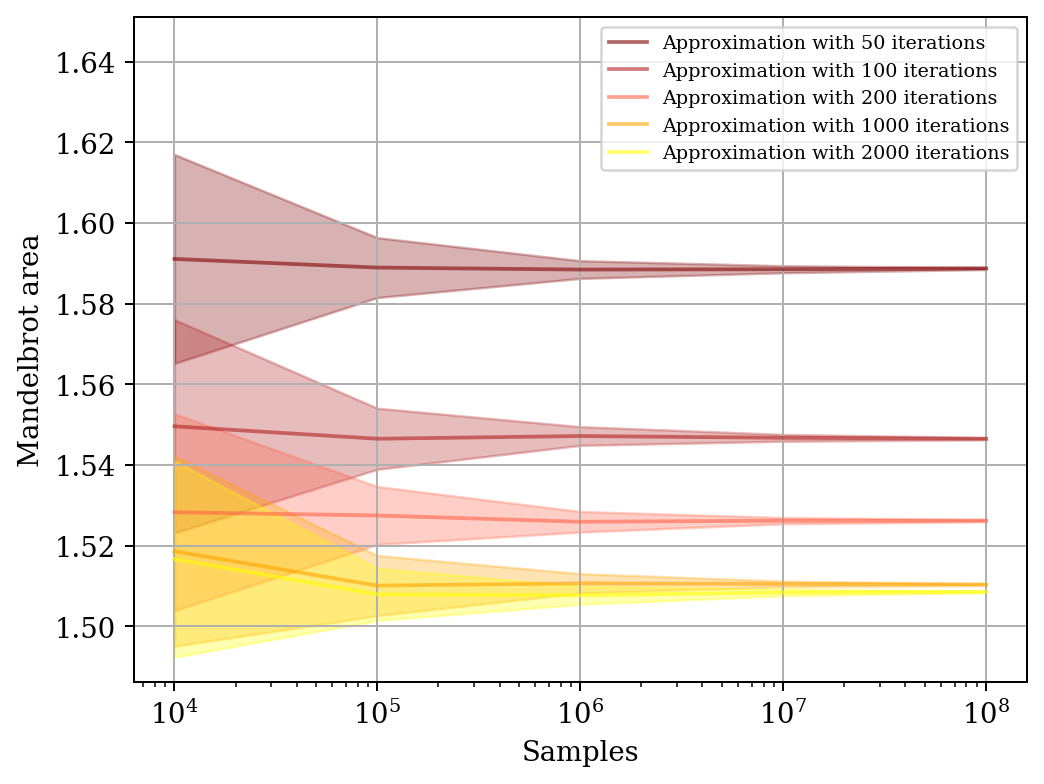

In [23]:
sample_variance_plotter_appendix(simulation_data = "monte_carlo_random_sampling", title = "line_plot_samples_random_appendix.png")

In [24]:
def iteration_variance_plotter_appendix(simulation_data, title):
    """"
    Plots mean area and standard deviation of the mandelbrot set 
    against sample sizes simulated with different number of 
    iterations
    """
    i_values = np.array([50, 100, 200, 500, 1000, 2000], dtype = np.int64) 
    
    data = np.load(simulation_data + ".npz")
    
    mean_areas = data['arr_0']*2
    
    sample_variances = data['arr_1']*2
    
    mean_s_10_4 = [i[0] for i in mean_areas]
    mean_s_10_5 = [i[1] for i in mean_areas]
    mean_s_10_6 = [i[2] for i in mean_areas]
    mean_s_10_7 = [i[3] for i in mean_areas]
    mean_s_10_8 = [i[4] for i in mean_areas]

    std_s_10_4 = np.sqrt([i[0] for i in sample_variances])
    std_s_10_5 = np.sqrt([i[1] for i in sample_variances])
    std_s_10_6 = np.sqrt([i[2] for i in sample_variances])
    std_s_10_7 = np.sqrt([i[3] for i in sample_variances])
    std_s_10_8 = np.sqrt([i[4] for i in sample_variances])


    plt.plot(i_values, mean_s_10_4, alpha = 0.5, label = "Approximation with $10^4$ samples")
    plt.fill_between(i_values, mean_s_10_4 - std_s_10_4, mean_s_10_4 + std_s_10_4, alpha = 0.2)

    plt.plot(i_values, mean_s_10_5, alpha = 0.5, label = "Approximation with $10^5$ samples")
    plt.fill_between(i_values, mean_s_10_5 - std_s_10_5, mean_s_10_5 + std_s_10_5, alpha = 0.2)
    
    plt.plot(i_values, mean_s_10_6, alpha = 0.5, label = "Approximation with $10^6$ samples")
    plt.fill_between(i_values, mean_s_10_6 - std_s_10_6, mean_s_10_6 + std_s_10_6, alpha = 0.2)
    
    plt.plot(i_values, mean_s_10_7, alpha = 0.5, label = "Approximation with $10^7$ samples")
    plt.fill_between(i_values, mean_s_10_7 - std_s_10_7, mean_s_10_7 + std_s_10_7, alpha = 0.2)
    
    plt.plot(i_values, mean_s_10_8, alpha = 0.5, label = "Approximation with $10^8$ samples")
    plt.fill_between(i_values, mean_s_10_8 - std_s_10_8, mean_s_10_8 + std_s_10_8, alpha = 0.2)
    
    #plt.hlines(1.50659, i_values[0], i_values[-1], label = "Theoretical Mandelbrot area", linestyles="dashed")

    plt.xlabel("Iterations")
    plt.ylabel("Mandelbrot area")
    plt.grid(True)
    plt.legend(loc="upper right", fontsize="x-small")
    
    plt.savefig(title)
    plt.show() 
    

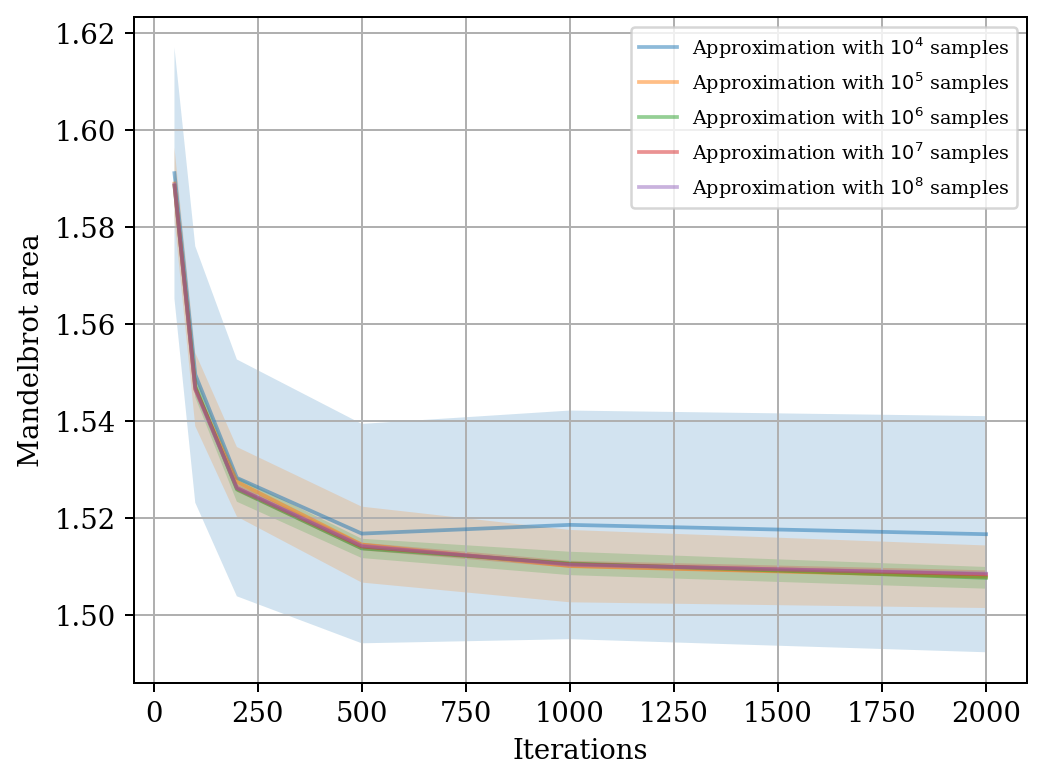

In [25]:
iteration_variance_plotter_appendix(simulation_data = "monte_carlo_random_sampling", title = "line_plot_iterations_random.png")

In [26]:
def sample_variance_box_plot(random_sampling_data, lhs_data, orthogonal_sampling_data, title):
    
    box_plot_list = [[], [], []]
    
    if data == np.load(random_sampling_data + ".npz"):
        mean_areas = data['arr_0']*2
        sample_variances = data['arr_1']*2 
        print(mean_i_100 = mean_areas[1])

    

In [27]:
l_bounds, u_bounds = (0, 0), (1, 1)
nax = 3
nsq = nax * nax
x_randos, y_randos = random_uniform_orthogonal(nax, l_bounds, u_bounds)

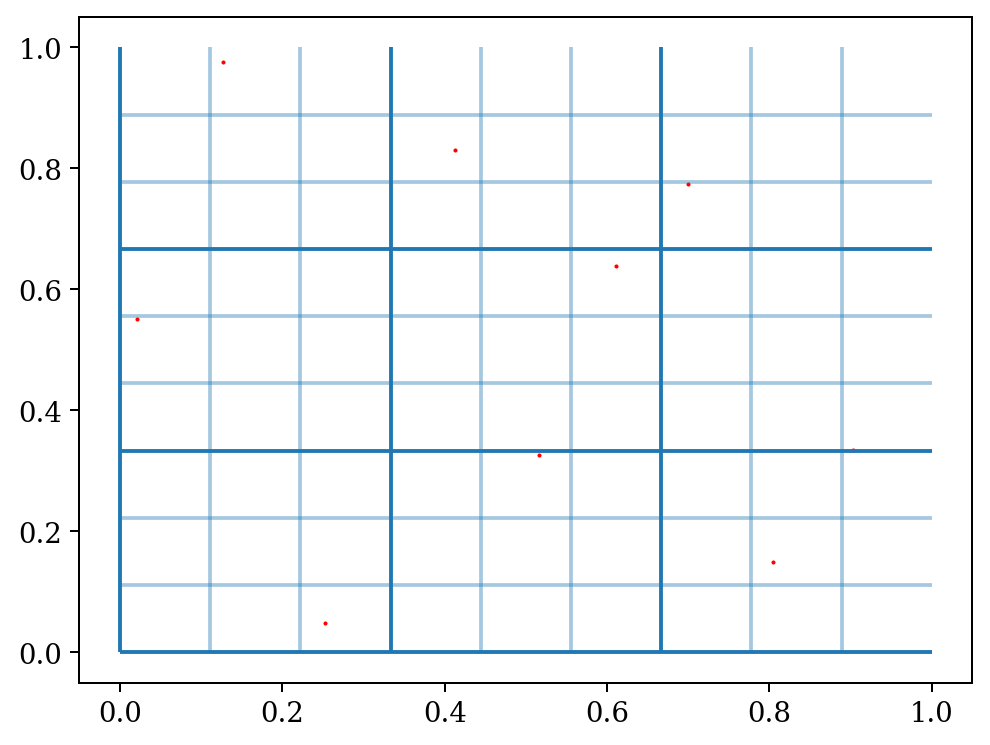

In [28]:
plt.scatter(x_randos, y_randos, s = 0.4, c = "red") #TODO?: colourscheme
plt.hlines(np.arange(nsq)/nsq, 0, 1, alpha=0.4) # TODO?: replace these with plt.grid with controls
plt.vlines(np.arange(nsq)/nsq, 0, 1, alpha=0.4)
plt.hlines(np.arange(nax)/nax, 0, 1)
plt.vlines(np.arange(nax)/nax, 0, 1)
# plt.grid(b = True)
plt.show()

In [29]:
def sampling_methods(n):
    nx = ny = n
    nsq = n**2
    
    p_r = np.random.random((nsq, 2))
    
    sampler = stats.qmc.LatinHypercube(d=2)
    lhc = sampler.random(nsq)
    
    l_bounds, u_bounds = (0, 0), (1, 1)
    x_randos, y_randos = random_uniform_orthogonal(n, l_bounds, u_bounds)
    
    #fig = plt.figure(figsize=(10, 10))
    plt.scatter(p_r[:, 0], p_r[:, 1], color="b", label="Pure random")
    plt.scatter(lhc[:, 0], lhc[:, 1], color="r", label="LHC")
    plt.scatter(x_randos, y_randos, color="g", label="Orthogonal")
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.hlines(np.arange(nsq)/nsq, 0, 1, alpha = 0.7, color="b")
    plt.vlines(np.arange(nsq)/nsq, 0, 1, alpha = 0.7, color="b")
    plt.hlines(np.arange(n)/n, 0, 1, color="g")
    plt.vlines(np.arange(n)/n, 0, 1, color="g")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend(loc = "best")
    plt.show()

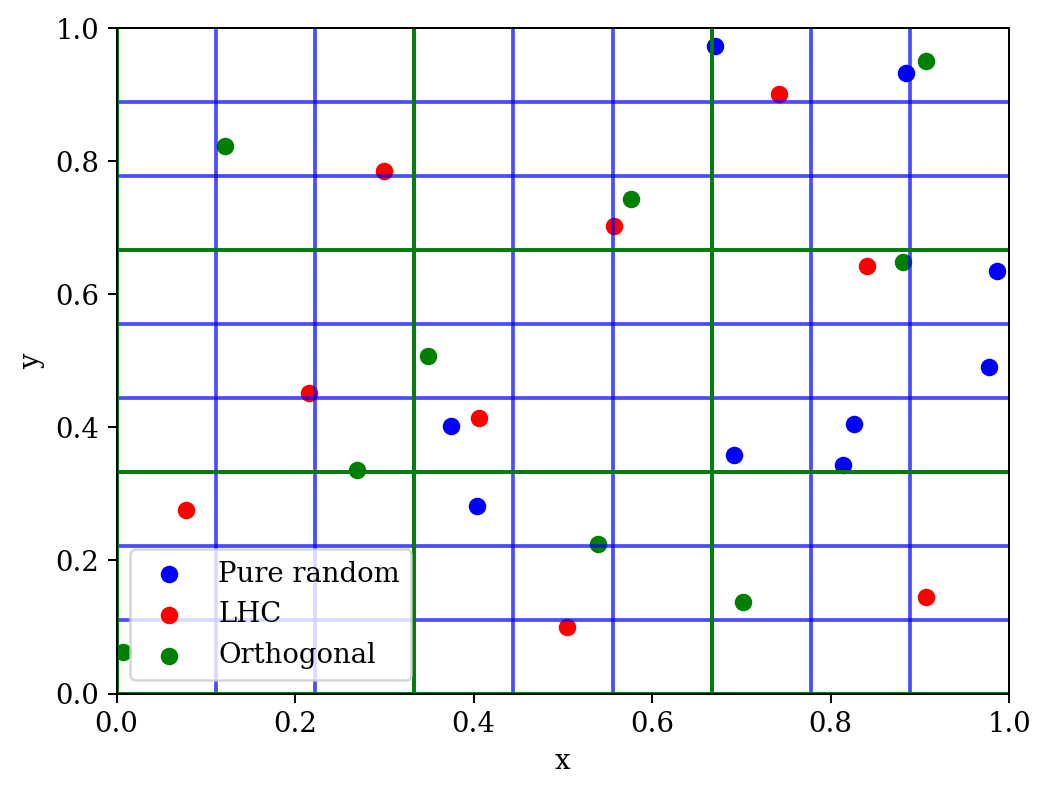

In [30]:
sampling_methods(n=3)

In [31]:
i_values = np.array([1000, 2000, 3000, 4000, 5000], dtype = np.int64) #TODO: tweak values
s_values = np.array([10**i for i in range(4,8)], dtype = np.int64)
npz_filename = "mc_random_fullsave.npz"
if not exists(npz_filename):
    re_low, re_high = -2., 1.
    im_low, im_high = 0, 1.5

    number_of_batches = 50
    areas = np.empty((len(i_values),len(s_values), number_of_batches))
    mean_areas = np.zeros((len(i_values), len(s_values)))
    sample_variances = np.zeros((len(i_values), len(s_values)))

    start_time = timer()
    for k,i in enumerate(i_values):
        # repeat `number_of_batches` times for each s-value
        for l,s in enumerate(s_values):
            print(f"Working with i = {i}, s = {s}.")
#             areas_batch = np.zeros(number_of_batches)
            for j in range(number_of_batches):
                samples = create_batch_uniform(s, re_low, re_high, im_low, im_high)
                iter_counts = mandelbrot_mc_default(i, samples)
                est_area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
                areas[k][l][j] = est_area
            μ, svar = sample_mean_variance(areas[k][l])
            mean_areas[k][l] = μ
            sample_variances[k][l] = svar
    end_time = timer()
    np.savez(npz_filename, mean_areas, sample_variances, areas) 
else:
    save_data = np.load(npz_filename)
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']
    areas = save_data['arr_2']

In [32]:
full_random = np.load("mc_random_fullsave.npz")

#print(full_random['arr_0']*2)
print(full_random['arr_2']*2)

[[[1.5192    1.5525    1.5705    1.5363    1.4787    1.4553    1.4886
   1.4742    1.5759    1.4796    1.5192    1.5084    1.5021    1.4994
   1.5156    1.4796    1.5399    1.5165    1.4814    1.485     1.521
   1.5084    1.4841    1.5642    1.5165    1.5336    1.4958    1.5057
   1.521     1.4949    1.5408    1.5696    1.5246    1.4877    1.5273
   1.4841    1.4391    1.5003    1.4778    1.4616    1.5822    1.4535
   1.512     1.5147    1.5273    1.521     1.5174    1.5534    1.5012
   1.5363   ]
  [1.50867   1.50813   1.53972   1.50426   1.5012    1.51839   1.52973
   1.51182   1.49328   1.50048   1.50768   1.50849   1.51623   1.51596
   1.51335   1.51236   1.52406   1.5255    1.5003    1.50849   1.50489
   1.52451   1.50615   1.53126   1.49769   1.51965   1.51353   1.50057
   1.51677   1.49337   1.50255   1.51533   1.52451   1.52595   1.51542
   1.52334   1.52271   1.50237   1.49958   1.49913   1.52253   1.51893
   1.51002   1.52523   1.51227   1.51722   1.50498   1.52145   1.50102


In [33]:
i_values = np.array([1000, 2000, 3000, 4000, 5000], dtype = np.int64) #TODO: tweak values
s_values = np.array([10**i for i in range(4,8)], dtype = np.int64)
def sample_variance_plotter(simulation_data, title):
    """"
    Plots mean area and standard deviation of the mandelbrot set 
    against sample sizes simulated with different number of 
    iterations
    """
    data = np.load(simulation_data + ".npz")
    
    mean_areas = data['arr_0']*2
    
    sample_variances = data['arr_1']*2
    
    mean_i_1000 = mean_areas[0]
    mean_i_2000 = mean_areas[1]
    mean_i_3000 = mean_areas[2]
    mean_i_4000 = mean_areas[3]
    mean_i_5000 = mean_areas[4]


    std_i_1000 = np.sqrt(sample_variances[0])
    std_i_2000 = np.sqrt(sample_variances[1])
    std_i_3000 = np.sqrt(sample_variances[2])
    std_i_4000 = np.sqrt(sample_variances[3])
    std_i_5000 = np.sqrt(sample_variances[4])


    plt.plot(s_values, mean_i_1000, color = "maroon", alpha = 0.6, label = "i = 1000")
    plt.fill_between(s_values, mean_i_1000 - std_i_1000, mean_i_1000 + std_i_1000, alpha = 0.2, color = "maroon")

    plt.plot(s_values, mean_i_2000, color = "firebrick", alpha = 0.6, label = "i = 2000")
    plt.fill_between(s_values, mean_i_2000 - std_i_2000, mean_i_2000 + std_i_2000, alpha = 0.2, color = "firebrick")

    plt.plot(s_values, mean_i_3000, color = "tomato", alpha = 0.6, label = "i = 3000")
    plt.fill_between(s_values, mean_i_3000 - std_i_3000, mean_i_3000 + std_i_3000, alpha = 0.2, color = "tomato")

    plt.plot(s_values, mean_i_4000, color = "orange", alpha = 0.6, label = "i = 4000")
    plt.fill_between(s_values, mean_i_4000 - std_i_4000, mean_i_4000 + std_i_4000, alpha = 0.2, color = "orange")

    plt.plot(s_values, mean_i_5000, color = "yellow", alpha = 0.6, label = "i = 5000")
    plt.fill_between(s_values, mean_i_5000 - std_i_5000, mean_i_5000 + std_i_5000, alpha = 0.2, color = "yellow")

    #plt.hlines(1.50659, s_values[0], s_values[-1], label = "Theoretical Mandelbrot area", linestyles="dashed")

    #plt.ylim(top=max(mean_i_50)+0.06) 
    plt.xscale('log')
    plt.xlabel("Samples")
    plt.ylabel("Mandelbrot area")
    plt.grid(True)
    plt.legend(loc="upper right", fontsize="x-small")
    
    plt.savefig(title)
    plt.show() 

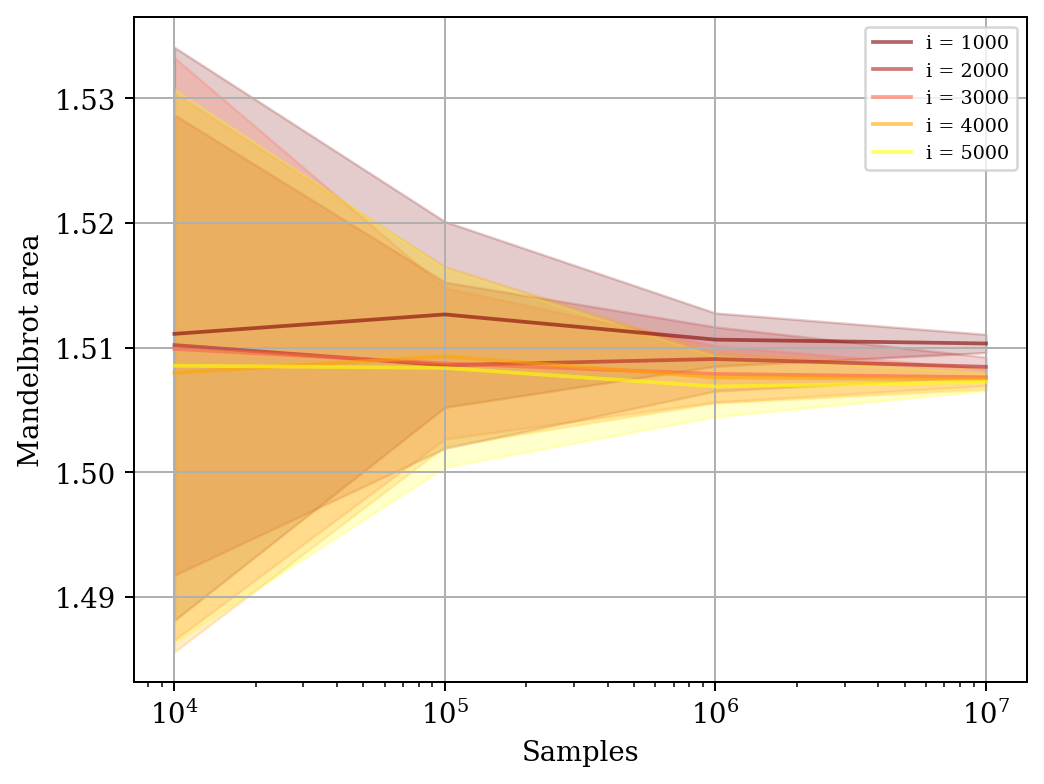

In [34]:
sample_variance_plotter(simulation_data = "mc_random_fullsave", title = "line_plot_samples_random.png")

In [35]:
full_random = np.load("mc_random_fullsave.npz")

full_random_variances = full_random['arr_1']*2
full_random_means = full_random['arr_0']*2

print(full_random_means)

confidence_intervals(sample_variances = full_random_variances, p = 0.05)

[[1.5111     1.5126606  1.51063686 1.51032649]
 [1.5102     1.50858    1.50908148 1.50845161]
 [1.509894   1.5087258  1.5078816  1.50761317]
 [1.507968   1.5092982  1.5075981  1.50747793]
 [1.508544   1.5083658  1.50687396 1.50724595]]


array([[0.02857378, 0.00926187, 0.00265071, 0.00090582],
       [0.02295857, 0.00828494, 0.00319529, 0.00096893],
       [0.0290381 , 0.00753942, 0.0027978 , 0.00084402],
       [0.02783565, 0.00896103, 0.00253476, 0.00102593],
       [0.02760401, 0.00989682, 0.00301231, 0.00087698]])

In [36]:
full_random_runs_data = full_random['arr_2']*2
# s=10^6
i_1000 = full_random_runs_data[0][1]
i_2000 = full_random_runs_data[1][1]
i_3000 = full_random_runs_data[2][1]
i_4000 = full_random_runs_data[3][1]
i_5000 = full_random_runs_data[4][1]

print(i_5000)

[1.51245 1.49598 1.51434 1.51218 1.51695 1.5057  1.50615 1.51605 1.50588
 1.48887 1.49283 1.49589 1.50003 1.48608 1.51686 1.49148 1.51281 1.51101
 1.51587 1.50579 1.5174  1.52685 1.52784 1.51731 1.49202 1.49274 1.52928
 1.50552 1.50939 1.52406 1.50408 1.5264  1.49778 1.51965 1.49985 1.512
 1.50039 1.50489 1.5246  1.50723 1.51245 1.50381 1.51839 1.49787 1.50822
 1.49931 1.50138 1.52658 1.49346 1.51434]


In [37]:
print("Welch test max iterations and i=1000:")
print(stats.ttest_ind(i_1000, i_5000))
print("Welch test max iterations and i=2000:")
print(stats.ttest_ind(i_2000, i_5000))
print("Welch test max iterations and i=3000:")
print(stats.ttest_ind(i_3000, i_5000))
print("Welch test max iterations and i=4000:")
print(stats.ttest_ind(i_4000, i_5000))

Welch test max iterations and i=1000:
Ttest_indResult(statistic=1.9671061846838118, pvalue=0.051998526311467695)
Welch test max iterations and i=2000:
Ttest_indResult(statistic=0.10303214405405932, pvalue=0.9181480031435756)
Welch test max iterations and i=3000:
Ttest_indResult(statistic=0.1796409647119506, pvalue=0.857805355128294)
Welch test max iterations and i=4000:
Ttest_indResult(statistic=0.43357594393617543, pvalue=0.6655493255316912)


In [38]:
i_1000_s_10_5 = full_random_runs_data[0][1]
i_1000_s_10_6 = full_random_runs_data[0][2]
i_2000_s_10_5 = full_random_runs_data[1][1]
i_2000_s_10_6 = full_random_runs_data[1][2]
i_3000_s_10_5 = full_random_runs_data[2][1]
i_3000_s_10_6 = full_random_runs_data[2][2]
print(i_1000_s_10_5)

[1.50867 1.50813 1.53972 1.50426 1.5012  1.51839 1.52973 1.51182 1.49328
 1.50048 1.50768 1.50849 1.51623 1.51596 1.51335 1.51236 1.52406 1.5255
 1.5003  1.50849 1.50489 1.52451 1.50615 1.53126 1.49769 1.51965 1.51353
 1.50057 1.51677 1.49337 1.50255 1.51533 1.52451 1.52595 1.51542 1.52334
 1.52271 1.50237 1.49958 1.49913 1.52253 1.51893 1.51002 1.52523 1.51227
 1.51722 1.50498 1.52145 1.50102 1.512  ]


In [39]:
import scipy

print(scipy.stats.ttest_1samp(i_1000_s_10_5, 1.5065918849))
print(scipy.stats.ttest_1samp(i_1000_s_10_6, 1.5065918849))
print(scipy.stats.ttest_1samp(i_2000_s_10_5, 1.5065918849))
print(scipy.stats.ttest_1samp(i_2000_s_10_6, 1.5065918849))

Ttest_1sampResult(statistic=4.0679155810955185, pvalue=0.00017188446890088508)
Ttest_1sampResult(statistic=9.473872945788596, pvalue=1.1734234180985612e-12)
Ttest_1sampResult(statistic=1.4897942910892212, pvalue=0.14268744574411588)
Ttest_1sampResult(statistic=4.837184534418119, pvalue=1.3489719361716625e-05)


## Orthogonal Sampling
$s = 3000$ gave us a 95% confidence interval of half-width $ < 10^{-3}$. We expect latin hypercube and orthogonal
sampling methods to give us a significantly smaller confidence interval.

In [46]:
@njit
def run_batch(s, i, re_low, re_high, im_low, im_high, batch_size, batch_generator):
    areas = np.empty(batch_size, dtype = np.float64)
    for batch in range(batch_size):
        samples = batch_generator(s, re_low, re_high, im_low, im_high)
        iter_counts = mandelbrot_mc_default(i, samples)
        area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
        areas[batch] = area
    return areas
    
def run_batch_lhc(s, i, re_low, re_high, im_low, im_high, batch_size, seed = None):
    areas = np.empty(batch_size, dtype = np.float64)
    for batch in range(batch_size):
        samples = create_batch_lhc(s, re_low, re_high, im_low, im_high, seed = seed)
        iter_counts = mandelbrot_mc_default(i, samples)
        areas[batch] = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
    return areas

In [41]:
area_from_iter_counts?

In [42]:
s = 10**8
i_values = np.array([3000,4000,5000])

re_low, re_high = -2, 1
im_low, im_high = 0, 1.5

number_of_batches = 50

npz_filename = "mc_orthogonal.npz"
areas = []
if not exists(npz_filename):
    for i in i_values:
        print(f"Working with i = {i}")
        areas.append(run_batch(s, i, re_low, re_high, im_low, im_high, number_of_batches, create_batch_orthogonal))
    stats = [sample_mean_variance(batch) for batch in areas]
    mean_areas = np.array([stat[0] for stat in stats])
    sample_variances = np.array([stat[1] for stat in stats])
    areas = np.array(areas)
    np.savez(npz_filename, mean_areas, sample_variances, areas)
else:
    save_data = np.load(npz_filename)
    keys = [f"arr_{i}" for i in range(3)]
    mean_areas, sample_variances, areas = (save_data[key] for key in keys)

## Latin Hypercube Sampling

In [43]:
s = 10**8
i_values = np.array([3000,4000,5000])

re_low, re_high = -2, 1
im_low, im_high = 0, 1.5

number_of_batches = 50

npz_filename = "mc_lhc.npz"
areas = []
if not exists(npz_filename):
    for i in i_values:
        areas.append(run_batch_lhc(s, i, re_low, re_high, im_low, im_high, number_of_batches))
    statistics = [sample_mean_variance(batch) for batch in areas]
    mean_areas = np.array([stat[0] for stat in statistics])
    sample_variances = np.array([stat[1] for stat in statistics])
    areas = np.array(areas)
    np.savez(npz_filename, mean_areas, sample_variances, areas)
else:
    save_data = np.load(npz_filename)
    keys = [f"arr_{i}" for i in range(3)]
    mean_areas, sample_variances, areas = (save_data[key] for key in keys)

## Comparison between PRS, LHC, and OS
Fix $i, s$ and vary the number of runs

In [61]:
i = 1000
s = 10**6
batch_sizes = np.array([50, 100, 250, 500, 750])

npz_filename = "sampling_methods_comparison.npz"

re_low, re_high = -2., 1.
im_low, im_high = 0., 1.5


if not exists(npz_filename):
    mean_areas = np.array([np.empty(len(batch_sizes)) for _ in range(3)])
    sample_variances = np.array([np.empty(len(batch_sizes)) for _ in range(3)])

    #pure random sampling
    for k,bsize in enumerate(batch_sizes):
        areas_batch = np.empty(bsize, dtype = np.float64)
        for b in range(bsize):
            samples = create_batch_uniform(s, re_low, re_high, im_low, im_high)
            iter_counts = mandelbrot_mc_default(i, samples)
            area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
            areas_batch[b] = area
        μ, σsq = sample_mean_variance(areas_batch)
        mean_areas[0][k] = μ
        sample_variances[0][k] = σsq
        
    #orthogonal sampling
    for k,bsize in enumerate(batch_sizes):
        areas_batch = np.empty(bsize, dtype = np.float64)
        for b in range(bsize):
            samples = create_batch_orthogonal(s, re_low, re_high, im_low, im_high)
            iter_counts = mandelbrot_mc_default(i, samples)
            area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
            areas_batch[b] = area
        μ, σsq = sample_mean_variance(areas_batch)
        mean_areas[1][k] = μ
        sample_variances[1][k] = σsq
        
    #latin hypercube sampling
    for k,bsize in enumerate(batch_sizes):
        areas_batch = np.empty(bsize, dtype = np.float64)
        for b in range(bsize):
            samples = create_batch_lhc(s, re_low, re_high, im_low, im_high)
            iter_counts = mandelbrot_mc_default(i, samples)
            area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
            areas_batch[b] = area
        μ, σsq = sample_mean_variance(areas_batch)
        mean_areas[2][k] = μ
        sample_variances[2][k] = σsq       
        
    print(mean_areas * 2)
    np.savez(npz_filename, mean_areas, sample_variances)
else:
    save_data = np.load(npz_filename)
    indices = (f"arr_{i}" for i in range(2))
    mean_areas, sample_variances = (save_data[i] for i in indice)

[[1.55025 1.48518]
 [1.55115 1.54134]
 [1.52505 1.51776]]


In [68]:
i = 1000
s = 10**6
number_of_batches = 50 # TODO: decide value from previous cell's results

npz_filename = "3_sampling_methods_one_run.npz"

re_low, re_high = -2., 1.
im_low, im_high = 0., 1.5

generators = [create_batch_uniform, create_batch_orthogonal, create_batch_lhc]

if not exists(npz_filename):
    areas = np.empty((3,number_of_batches))
    mean_areas = mean_areas = np.empty(3)
    sample_variances = np.empty(3)

    
    for k, method in enumerate(generators):
        for b in range(number_of_batches):
            samples = method(s, re_low, re_high, im_low, im_high)
            iter_counts = mandelbrot_mc_default(i, samples)
            area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
            areas[k][b] = area
        μ, σsq = sample_mean_variance(areas[k])
        mean_areas[k] = μ
        sample_variances[k] = σsq
       
    print(mean_areas * 2)
    np.savez(npz_filename, mean_areas, sample_variances, areas)
else:
    save_data = np.load(npz_filename)
    indices = (f"arr_{i}" for i in range(3))
    mean_areas, sample_variances, areas = (save_data[i] for i in indice)

[1.4949  1.54998 1.51794]
